# <font style="color:blue">Project 1 - Part 2: Train an Image Classifier From Scratch</font>
As discussed in the previous notebook, the steps for training Neural Networks are:

- Step 1 - Understand your problem
- Step 2A - Get the data
- Step 2B - Explore and understand your data
- Step 2C - Create a sample data from the dataset
- Step 3 - Data preparation
- Step 4 - Train a simple model on sample data and check the pipeline before proceeding to train the full network
- Step 5 - Train on full Data
- Step 6 - Improve your model
- Step 7 - Generate Submission file


Follow Steps 1-4 exactly as you did in the previous notebook. Here, you will implement Steps 5, 6 & 7 from scratch.


There are **70 points** for this notebook. <font style="color:red">The sections which carry marks are in Red.</font>


**To achieve full marks in this notebook design a model that achieves `>=85%` Public Test accuracy on the given dataset.**

**<font style="color:red">Build your own model from scratch, and do not use any pre-trained models/weights.</font>**





**After completing the project, upload and submit the notebook to the lab for feedback.**

**<font style="color:red">You need to achieve atleast 80% accuracy on the Public test leaderboard to successfully complete this project.</font>**

# <font style="color:blue">Step 1: Understand Your problem </font><a name="step1"></a>
Already covered in the previous notebook.

## <font style="color:blue">3.1. Import Libraries </font>

In [27]:
import os
import time
from dataclasses import dataclass
from typing import List, Union, Tuple

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter

from torchvision import datasets, transforms

from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassAccuracy



# Text formatting
bold = "\033[1m"
end = "\033[0m"

plt.style.use('ggplot')
block_plot=False

%matplotlib inline

### <font style="color:green">3.2.1. Compulsary Preprocessing Transforms</font>

In [28]:
def image_preprocess_transforms(img_size):
    preprocess = transforms.Compose(
        [
            transforms.Resize(img_size),
            transforms.ToTensor(),
        ]
    )

    return preprocess

### <font style="color:green">3.2.2. Common Image Transforms</font>

In [29]:
def image_common_transforms(img_size=(224, 224), mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)):
    preprocess = image_preprocess_transforms(img_size)

    common_transforms = transforms.Compose(
        [
            preprocess,
            transforms.Normalize(mean, std),
        ]
    )

    return common_transforms

### <font style="color:green">3.2.3. Mean and STD</font>

Function for Calculating Mean and Variance.

In [30]:
def get_mean_std(data_root, img_size=(224, 224), num_workers=4):
    transform = image_preprocess_transforms(img_size=img_size)

    loader = data_loader(data_root, transform)

    batch_mean = torch.zeros(3)
    batch_mean_sqrd = torch.zeros(3)

    for batch_data, _ in loader:
        batch_mean += batch_data.mean(dim=(0, 2, 3))  # E[batch_i]
        batch_mean_sqrd += (batch_data**2).mean(dim=(0, 2, 3))  #  E[batch_i**2]

    # E[dataset] = E[E[batch_1], E[batch_2], ...]
    mean = batch_mean / len(loader)

    # var[X] = E[X**2] - E[X]**2

    # E[X**2] = E[E[batch_1**2], E[batch_2**2], ...]
    # E[X]**2 = E[E[batch_1], E[batch_2], ...] ** 2

    var = (batch_mean_sqrd / len(loader)) - (mean**2)

    std = var**0.5
    print("mean: {}, std: {}".format(mean, std))

    return mean, std

## <font style="color:blue">3.3. Data Loaders </font>

### <font style="color:green">3.3.1. Data Loader for Full Data</font>
Data loader for generating batches of data to be used by the training routine

In [31]:
def data_loader(data_root, transform, batch_size=16, shuffle=False, num_workers=2):
    dataset = datasets.ImageFolder(root=data_root, transform=transform)

    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
    )

    return loader

def subset_data_loader(data_root, transform, batch_size=8, shuffle=False, num_workers=2, subset_size=0.05):
    dataset = datasets.ImageFolder(root=data_root, transform=transform)

    data_subset = torch.utils.data.Subset(
        dataset,
        np.arange(0, len(dataset), 1.0 / subset_size).astype(int),
    )

    loader = torch.utils.data.DataLoader(data_subset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return loader

def data_augmentation_preprocess(mean, std):
    augmented_transform = transforms.Compose([
        transforms.ToPILImage(),  # Convert tensor to PIL Image FIRST
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),  # Convert back to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return augmented_transform

## <font style="color:green">3.4. Prepare Data</font>
The main function which uses all the above functions to generate the train and valid dataloaders.


In [32]:
def get_data(batch_size, data_root, img_size=(224, 224), num_workers=4, data_augmentation=False):
    train_data_path = os.path.join(data_root, "Train")

    mean, std = get_mean_std(data_root=train_data_path, img_size=img_size, num_workers=num_workers)

    common_transforms = image_common_transforms(img_size, mean, std)

    # If data_augmentation is true data augmentation will be applied.
    if data_augmentation:
        train_transforms = data_augmentation_preprocess(mean, std)
    # Else simply do common transforms
    else:
        train_transforms = common_transforms

    # Train dataloader
    train_loader = subset_data_loader(
        train_data_path,
        train_transforms,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    # Valid dataloader
    valid_data_path = os.path.join(data_root, "Valid")

    valid_loader = subset_data_loader(
        valid_data_path,
        common_transforms,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, valid_loader


# <font style="color:blue">Step 4: Train Your Model</font><a name="step4"></a>

Now, create the training pipeline, and train your model on the full data.

## <font style="color:red">4.1. Configurations [5 Points]</font>

To achieve good results, change the parameters given in these configurations.

### <font style="color:green">4.1.1. System Configuration</font>

Fix the seed (e.g., `21`) to get a reproducible result. 

In [33]:
@dataclass
class SystemConfig:
    """
    Describes the common system setting needed for reproducible training
    """

    seed: int = 21  # Seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # Enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # Make cudnn deterministic (reproducible training)

### <font style="color:green">4.1.2. Training Configuration</font>

In [34]:
@dataclass
class TrainingConfig:
    """
    Describes configuration of the training process
    """

    num_classes: int = 3
    batch_size: int = 32
    img_size: Tuple = (224, 224)
    epochs_count: int = 100
    init_learning_rate: float = 0.001  # Use a lower LR for stable training
    data_root: str = "/kaggle/input/opencv-pytorch-project-1-classification/dataset"
    num_workers: int = 10
    device: str = "cuda"

    # For tensorboard logging and saving checkpoints
    save_model_name: str = "cat_dog_panda_classifier.pt"
    root_log_dir: str = os.path.join("Logs_Checkpoints", "Model_logs")
    root_checkpoint_dir: str = os.path.join("Logs_Checkpoints", "Model_checkpoints")

    # Current log and checkpoint directory.
    log_dir: str = "version_0"
    checkpoint_dir: str = "version_0"

    decay_rate: float = 0.1  # Reduced decay rate
    weight_decay: float = 0.01  # Added L2 regularization
    scheduler_patience: int = 5  # Added patience for learning rate scheduler
    scheduler_factor: float = 0.5  # Added factor for learning rate reduction

### <font style="color:green">4.1.3. System Setup</font>

In [35]:
def setup_system(system_config: SystemConfig) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

## <font style="color:blue">4.2. Training Function</font>

In the next code cell, we are going to define the training function, which is a crucial step in our deep learning pipeline. This function will handle the processes involved in training, including feeding data to the model, adjusting weights, and optimizing performance.

You are already familiar with the training function. No changes needed here.

In [36]:
import torch
def train(
    train_config: TrainingConfig,
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader,
    epoch_idx: int,
    total_epochs: int,
) -> Tuple[float, float]:
    
    # Change model in training mode.
    model.train()

    acc_metric = MulticlassAccuracy(num_classes=train_config.num_classes, average="micro")
    mean_metric = MeanMetric()

    device = train_config.device

    status = f"Train:\t{bold}Epoch: {epoch_idx}/{total_epochs}{end}"

    prog_bar = tqdm(train_loader, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")

    prog_bar.set_description(status)

    for data, target in prog_bar:
        # Send data and target to appropriate device.
        data, target = data.to(device), target.to(device)

        # Reset parameters gradient to zero.
        optimizer.zero_grad()

        # Forward pass to the model.
        output = model(data)

        # Cross Entropy loss
        loss = F.cross_entropy(output, target)

        # Find gradients w.r.t training parameters.
        loss.backward()

        # Update parameters using gradients.
        optimizer.step()

        # Batch Loss.
        mean_metric(loss.item(), weight=data.shape[0])

        # # Get probability score using softmax.
        # prob = F.softmax(output, dim=1)

        # Get the index of the max probability.
        pred_idx = output.detach().argmax(dim=1)

        # Batch accuracy.
        acc_metric(pred_idx.cpu(), target.cpu())

        # Update progress bar description.
        step_status = status + f" Train Loss: {mean_metric.compute():.4f}, Train Acc: {acc_metric.compute():.4f}"
        prog_bar.set_description(step_status)

    epoch_loss = mean_metric.compute()
    epoch_acc = acc_metric.compute()

    prog_bar.close()

    return epoch_loss, epoch_acc

## <font style="color:blue">4.3. Validation Function</font>

In the upcoming code cell, we will create the validation function. This function is essential for assessing the performance of our model on unseen data, ensuring its effectiveness and accuracy.

In [37]:
def validate(
    train_config: TrainingConfig, 
    model: nn.Module, 
    valid_loader: torch.utils.data.DataLoader,
    epoch_idx: int, 
    total_epochs: int
) -> Tuple[float, float]:

    # Change model in evaluation mode.
    model.eval()

    acc_metric = MulticlassAccuracy(num_classes=train_config.num_classes, average="micro")
    mean_metric = MeanMetric()

    device = train_config.device

    status = f"Valid:\t{bold}Epoch: {epoch_idx}/{total_epochs}{end}"

    prog_bar = tqdm(valid_loader, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")

    prog_bar.set_description(status)

    for data, target in prog_bar:
        # Send data and target to appropriate device.
        data, target = data.to(device), target.to(device)

        # Get the model's predicted logits.
        with torch.no_grad():
            output = model(data)

        # Compute the CE-Loss.
        valid_loss = F.cross_entropy(output, target).item()

        # Batch validation loss.
        mean_metric(valid_loss, weight=data.shape[0])

        # # Convert model's logits to probability scores.
        # prob = F.softmax(output, dim=1)

        # Get the index of the max probability.
        pred_idx = output.detach().argmax(dim=1)

        # Batch accuracy.
        acc_metric(pred_idx.cpu(), target.cpu())

        # Update progress bar description.
        step_status = status + f" Valid Loss: {mean_metric.compute():.4f}, Valid Acc: {acc_metric.compute():.4f}"
        prog_bar.set_description(step_status)

    valid_loss = mean_metric.compute()
    valid_acc = acc_metric.compute()

    prog_bar.close()

    return valid_loss, valid_acc

## <font style="color:blue">4.4. Save & Load Model</font>

The following two code cells are dedicated to essential functions in deep learning model management:

1. **Saving the Model Function**: This function is crucial for preserving the trained model state, allowing us to store the learned parameters for future use or further analysis.

2. **Loading the Model Function**: This function is designed to retrieve and load a previously saved model. It's vital for resuming training, making predictions, or conducting evaluations without having to retrain the model from scratch.


In [38]:
def save_model(model, device, model_dir="models", model_file_name="cat_dog_panda_classifier.pt"):
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # Make sure you transfer the model to cpu.
    if device == "cuda":
        model.to("cpu")

    # Save the 'state_dict'
    torch.save(model.state_dict(), model_path)

    if device == "cuda":
        model.to("cuda")

    return

In [39]:
def load_model(model, model_dir="models", model_file_name="cat_dog_panda_classifier.pt", device=torch.device("cpu")):
    model_path = os.path.join(model_dir, model_file_name)

    # Load model parameters by using 'load_state_dict'.
    model.load_state_dict(torch.load(model_path, map_location=device))

    return model

## <font style="color:blue">4.5. Logging Setup</font>

This function will be initializing directories so that they save tensorboard and model checkpoints for different training versions.


In [40]:
def setup_log_directory(training_config=TrainingConfig()):
    """Tensorboard Log and Model checkpoint directory Setup"""

    if os.path.isdir(training_config.root_log_dir):
        # Get all folders numbers in the root_log_dir.
        folder_numbers = [int(folder.replace("version_", "")) for folder in os.listdir(training_config.root_log_dir)]

        # Find the latest version number present in the log_dir
        last_version_number = max(folder_numbers)

        # New version name
        version_name = f"version_{last_version_number + 1}"

    else:
        version_name = training_config.log_dir

    # Update the training config default directory.
    training_config.log_dir = os.path.join(training_config.root_log_dir, version_name)
    training_config.checkpoint_dir = os.path.join(training_config.root_checkpoint_dir, version_name)

    # Create new directory for saving new experiment version.
    os.makedirs(training_config.log_dir, exist_ok=True)
    os.makedirs(training_config.checkpoint_dir, exist_ok=True)

    print(f"Logging at: {training_config.log_dir}")
    print(f"Model Checkpoint at: {training_config.checkpoint_dir}")

    return training_config, version_name

## <font style="color:blue">4.6. Plot Loss and Accuracy</font>

The next code cell will focus on developing a function for plotting loss and accuracy graphs. This function is instrumental in visualizing the performance of the deep learning model throughout the training process, providing insights into its learning behavior by displaying trends in loss reduction and accuracy improvement over epochs.


In [41]:
def plot_loss_accuracy(
    train_loss,
    val_loss,
    train_acc,
    val_acc,
    colors,
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
    fig_size=(20, 10),
    sub_plot1=(1, 2, 1),
    sub_plot2=(1, 2, 2),
):
    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = min(train_loss[i])
        min_val_loss = min(val_loss[i])

        plt.plot(x_train, train_loss[i], linestyle="-", color=f"tab:{colors[i]}", label=f"TRAIN LOSS ({min_train_loss:.4})")
        plt.plot(x_val, val_loss[i], linestyle="--", color=f"tab:{colors[i]}", label=f"VALID LOSS ({min_val_loss:.4})")


    plt.xlabel("epoch no.")
    plt.ylabel("loss")
    plt.legend(loc=loss_legend_loc)
    plt.title("Training and Validation Loss")
    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = max(train_acc[i])
        max_val_acc = max(val_acc[i])

        plt.plot(
            x_train,
            train_acc[i],
            linestyle="-",
            color=f"tab:{colors[i]}",
            label=f"TRAIN ACC ({max_train_acc:.4})",
        )

        plt.plot(
            x_val,
            val_acc[i],
            linestyle="--",
            color=f"tab:{colors[i]}",
            label=f"VALID ACC ({max_val_acc:.4})",
        )


    plt.xlabel("epoch no.")
    plt.ylabel("accuracy")
    plt.legend(loc=acc_legend_loc)
    plt.title("Training and Validation Accuracy")
    fig.savefig("sample_loss_acc_plot.png")
    plt.show()

    return

## <font style="color:blue">4.7. Main Function for Training</font>

In this function, we integrate all the various functions we've previously defined, creating a cohesive and streamlined workflow.

In [42]:
def main(model, summary_writer, scheduler=None, system_config=SystemConfig(), training_config=TrainingConfig(), data_augmentation=True):
    
    # Setup system configuration.
    setup_system(system_config)

    # Initialize data loader
    train_loader, valid_loader = get_data(
        batch_size=training_config.batch_size,
        data_root=training_config.data_root,
        img_size=training_config.img_size,
        num_workers=training_config.num_workers,
        data_augmentation=data_augmentation,
    )

    # Number of epochs to train.
    NUM_EPOCHS = training_config.epochs_count

    # Set acceleration device.
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # Send model to device (GPU/CPU)
    model.to(device)

    # Initialize Adam optimizer.
    optimizer = optim.Adam(model.parameters(), lr=training_config.init_learning_rate)

    best_loss = torch.tensor(np.inf)

    # Epoch train & valid loss accumulator.
    epoch_train_loss = []
    epoch_valid_loss = []

    # Epoch train & valid accuracy accumulator.
    epoch_train_acc = []
    epoch_valid_acc = []

    # Trainig time measurement
    t_begin = time.time()

    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train(training_config, model, optimizer, train_loader, epoch + 1, NUM_EPOCHS)
        val_loss, val_accuracy = validate(training_config, model, valid_loader, epoch + 1, NUM_EPOCHS)

        epoch_train_loss.append(train_loss)
        epoch_train_acc.append(train_acc)

        epoch_valid_loss.append(val_loss)
        epoch_valid_acc.append(val_accuracy)

        summary_writer.add_scalar("Loss/Train", train_loss, epoch)
        summary_writer.add_scalar("Accuracy/Train", train_acc, epoch)

        summary_writer.add_scalar("Loss/Validation", val_loss, epoch)
        summary_writer.add_scalar("Accuracy/Validation", val_accuracy, epoch)

        if val_loss < best_loss:
            best_loss = val_loss
            print(f"\nModel Improved... Saving Model ... ", end="")
            torch.save(model.state_dict(), os.path.join(training_config.checkpoint_dir, training_config.save_model_name))
            print("Done.\n")

        print(f"{'='*72}\n")

    print(f"Total time: {(time.time() - t_begin):.2f}s, Best Loss: {best_loss:.3f}")

    return epoch_train_loss, epoch_train_acc, epoch_valid_loss, epoch_valid_acc

## <font style="color:red">4.8. Define Model [10 Points]</font>

**Next, define your CNN model.**

Keep iterating. Do this by training various models.

Experiment by changing the:

* Number of layers.
* Number of filters/units per layer.
* Different types of layers, e.g., dropout, batch normalization.
* Different combination of layers.

In [52]:
import torch
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        self._body = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.SELU(inplace=True),  # Replaced ReLU with SELU
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.SELU(inplace=True),  # Replaced ReLU with SELU
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.SELU(inplace=True),  # Replaced ReLU with SELU
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.SELU(inplace=True),  # Replaced ReLU with SELU
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.SELU(inplace=True),  # Replaced ReLU with SELU
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.SELU(inplace=True),  # Replaced ReLU with SELU
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.SELU(inplace=True),  # Replaced ReLU with SELU
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.SELU(inplace=True),  # Replaced ReLU with SELU
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.SELU(inplace=True),  # Replaced ReLU with SELU
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.SELU(inplace=True),  # Replaced ReLU with SELU
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self._head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.SELU(inplace=True),
            nn.Dropout(0.6),  # Increased dropout rate
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.SELU(inplace=True),
            nn.Dropout(0.6),  # Increased dropout rate
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self._body(x)
        x = self._head(x)
        return x


## <font style="color:blue">4.9. Training</font>


In [53]:
model = MyModel()
#model = MyModel2(dropout=0.2, batch_norm=True)
print(model)

training_config = TrainingConfig()

# Model checkpoint log dir setup.
training_config, current_version_name = setup_log_directory(training_config)

# Tensorboard log dir setup.
summary_writer = SummaryWriter(training_config.log_dir)

MyModel(
  (_body): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SELU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): SELU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): SELU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, ker

In [56]:

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

# Train and Validate
train_loss, train_acc, val_loss, val_acc = main(
    model,
    summary_writer=summary_writer,
    scheduler=scheduler,
    system_config=SystemConfig(),
    training_config=training_config,
    data_augmentation=False,
)

mean: tensor([0.4573, 0.4348, 0.3884]), std: tensor([0.2686, 0.2601, 0.2600])


Train:	Epoch: 1/100 Train Loss: 1.0532, Train Acc: 0.6952: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]
Valid:	Epoch: 1/100 Valid Loss: 2.6828, Valid Acc: 0.4667: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 2/100 Train Loss: 0.6809, Train Acc: 0.7238: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]
Valid:	Epoch: 2/100 Valid Loss: 2.9068, Valid Acc: 0.4000: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Train:	Epoch: 3/100 Train Loss: 0.6098, Train Acc: 0.7810: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]
Valid:	Epoch: 3/100 Valid Loss: 1.6251, Valid Acc: 0.3333: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 4/100 Train Loss: 0.7117, Train Acc: 0.6667: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s]
Valid:	Epoch: 4/100 Valid Loss: 1.2610, Valid Acc: 0.2667: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 5/100 Train Loss: 0.5400, Train Acc: 0.7429: 100%|██████████| 4/4 [00:00<00:00,  4.00it/s]
Valid:	Epoch: 5/100 Valid Loss: 1.3561, Valid Acc: 0.3333: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Train:	Epoch: 6/100 Train Loss: 0.5479, Train Acc: 0.7905: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]
Valid:	Epoch: 6/100 Valid Loss: 1.1974, Valid Acc: 0.5333: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 7/100 Train Loss: 0.4586, Train Acc: 0.7905: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]
Valid:	Epoch: 7/100 Valid Loss: 3.0843, Valid Acc: 0.2000: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Train:	Epoch: 8/100 Train Loss: 0.5437, Train Acc: 0.8095: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]
Valid:	Epoch: 8/100 Valid Loss: 2.2953, Valid Acc: 0.2000: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Train:	Epoch: 9/100 Train Loss: 0.4352, Train Acc: 0.8286: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s]
Valid:	Epoch: 9/100 Valid Loss: 1.6770, Valid Acc: 0.2667: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Train:	Epoch: 10/100 Train Loss: 0.5156, Train Acc: 0.8190: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]
Valid:	Epoch: 10/100 Valid Loss: 1.5962, Valid Acc: 0.3333: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


Train:	Epoch: 11/100 Train Loss: 0.3931, Train Acc: 0.8667: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]
Valid:	Epoch: 11/100 Valid Loss: 4.3436, Valid Acc: 0.2000: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Train:	Epoch: 12/100 Train Loss: 0.5277, Train Acc: 0.8190: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]
Valid:	Epoch: 12/100 Valid Loss: 3.4299, Valid Acc: 0.2000: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


Train:	Epoch: 13/100 Train Loss: 0.4299, Train Acc: 0.8381: 100%|██████████| 4/4 [00:01<00:00,  3.54it/s]
Valid:	Epoch: 13/100 Valid Loss: 1.6516, Valid Acc: 0.3333: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Train:	Epoch: 14/100 Train Loss: 0.3433, Train Acc: 0.8476: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s]
Valid:	Epoch: 14/100 Valid Loss: 1.3076, Valid Acc: 0.4667: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Train:	Epoch: 15/100 Train Loss: 0.3678, Train Acc: 0.8476: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]
Valid:	Epoch: 15/100 Valid Loss: 1.6976, Valid Acc: 0.4667: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Train:	Epoch: 16/100 Train Loss: 0.4486, Train Acc: 0.8000: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]
Valid:	Epoch: 16/100 Valid Loss: 2.0908, Valid Acc: 0.4000: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Train:	Epoch: 17/100 Train Loss: 0.3770, Train Acc: 0.8762: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s]
Valid:	Epoch: 17/100 Valid Loss: 1.3083, Valid Acc: 0.5333: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


Train:	Epoch: 18/100 Train Loss: 0.3226, Train Acc: 0.8571: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]
Valid:	Epoch: 18/100 Valid Loss: 2.0860, Valid Acc: 0.2000: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Train:	Epoch: 19/100 Train Loss: 0.4168, Train Acc: 0.8000: 100%|██████████| 4/4 [00:00<00:00,  4.22it/s]
Valid:	Epoch: 19/100 Valid Loss: 2.9485, Valid Acc: 0.2667: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Train:	Epoch: 20/100 Train Loss: 0.3596, Train Acc: 0.8571: 100%|██████████| 4/4 [00:00<00:00,  4.15it/s]
Valid:	Epoch: 20/100 Valid Loss: 4.3770, Valid Acc: 0.2000: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Train:	Epoch: 21/100 Train Loss: 0.5023, Train Acc: 0.7905: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s]
Valid:	Epoch: 21/100 Valid Loss: 3.1849, Valid Acc: 0.2667: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Train:	Epoch: 22/100 Train Loss: 0.4885, Train Acc: 0.8095: 100%|██████████| 4/4 [00:01<00:00,  3.95it/s]
Valid:	Epoch: 22/100 Valid Loss: 1.5838, Valid Acc: 0.3333: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Train:	Epoch: 23/100 Train Loss: 0.3645, Train Acc: 0.8667: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s]
Valid:	Epoch: 23/100 Valid Loss: 2.2414, Valid Acc: 0.2667: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Train:	Epoch: 24/100 Train Loss: 0.3472, Train Acc: 0.8857: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]
Valid:	Epoch: 24/100 Valid Loss: 3.1377, Valid Acc: 0.2667: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


Train:	Epoch: 25/100 Train Loss: 0.4122, Train Acc: 0.8095: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s]
Valid:	Epoch: 25/100 Valid Loss: 1.4052, Valid Acc: 0.4667: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Train:	Epoch: 26/100 Train Loss: 0.4252, Train Acc: 0.8571: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s]
Valid:	Epoch: 26/100 Valid Loss: 1.5257, Valid Acc: 0.4000: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Train:	Epoch: 27/100 Train Loss: 0.3501, Train Acc: 0.8476: 100%|██████████| 4/4 [00:00<00:00,  4.18it/s]
Valid:	Epoch: 27/100 Valid Loss: 1.2197, Valid Acc: 0.3333: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Train:	Epoch: 28/100 Train Loss: 0.3767, Train Acc: 0.8381: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]
Valid:	Epoch: 28/100 Valid Loss: 1.3109, Valid Acc: 0.3333: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Train:	Epoch: 29/100 Train Loss: 0.4172, Train Acc: 0.8000: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s]
Valid:	Epoch: 29/100 Valid Loss: 1.4414, Valid Acc: 0.4667: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Train:	Epoch: 30/100 Train Loss: 0.3606, Train Acc: 0.8571: 100%|██████████| 4/4 [00:00<00:00,  4.08it/s]
Valid:	Epoch: 30/100 Valid Loss: 2.0193, Valid Acc: 0.3333: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Train:	Epoch: 31/100 Train Loss: 0.3781, Train Acc: 0.8190: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s]
Valid:	Epoch: 31/100 Valid Loss: 1.9140, Valid Acc: 0.3333: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Train:	Epoch: 32/100 Train Loss: 0.3424, Train Acc: 0.8667: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s]
Valid:	Epoch: 32/100 Valid Loss: 1.5640, Valid Acc: 0.4000: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Train:	Epoch: 33/100 Train Loss: 0.3546, Train Acc: 0.8476: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s]
Valid:	Epoch: 33/100 Valid Loss: 1.4237, Valid Acc: 0.4000: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Train:	Epoch: 34/100 Train Loss: 0.2851, Train Acc: 0.8857: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]
Valid:	Epoch: 34/100 Valid Loss: 1.4207, Valid Acc: 0.4667: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


Train:	Epoch: 35/100 Train Loss: 0.2790, Train Acc: 0.8952: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]
Valid:	Epoch: 35/100 Valid Loss: 1.8408, Valid Acc: 0.4000: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Train:	Epoch: 36/100 Train Loss: 0.3723, Train Acc: 0.9143: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s]
Valid:	Epoch: 36/100 Valid Loss: 1.5239, Valid Acc: 0.3333: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Train:	Epoch: 37/100 Train Loss: 0.2617, Train Acc: 0.9143: 100%|██████████| 4/4 [00:01<00:00,  4.00it/s]
Valid:	Epoch: 37/100 Valid Loss: 1.5130, Valid Acc: 0.6000: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Train:	Epoch: 38/100 Train Loss: 0.4126, Train Acc: 0.8476: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]
Valid:	Epoch: 38/100 Valid Loss: 2.5855, Valid Acc: 0.4000: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


Train:	Epoch: 39/100 Train Loss: 0.4201, Train Acc: 0.8381: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s]
Valid:	Epoch: 39/100 Valid Loss: 1.5998, Valid Acc: 0.5333: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Train:	Epoch: 40/100 Train Loss: 0.4121, Train Acc: 0.8476: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]
Valid:	Epoch: 40/100 Valid Loss: 0.7821, Valid Acc: 0.8000: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]



Model Improved... Saving Model ... Done.




Train:	Epoch: 41/100 Train Loss: 0.3213, Train Acc: 0.9048: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s]
Valid:	Epoch: 41/100 Valid Loss: 1.5304, Valid Acc: 0.5333: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Train:	Epoch: 42/100 Train Loss: 0.2830, Train Acc: 0.9048: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]
Valid:	Epoch: 42/100 Valid Loss: 3.1608, Valid Acc: 0.2667: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Train:	Epoch: 43/100 Train Loss: 0.2888, Train Acc: 0.8667: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s]
Valid:	Epoch: 43/100 Valid Loss: 2.4847, Valid Acc: 0.4000: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Train:	Epoch: 44/100 Train Loss: 0.3429, Train Acc: 0.8571: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]
Valid:	Epoch: 44/100 Valid Loss: 1.6871, Valid Acc: 0.4000: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


Train:	Epoch: 45/100 Train Loss: 0.3699, Train Acc: 0.7905: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]
Valid:	Epoch: 45/100 Valid Loss: 1.7182, Valid Acc: 0.4667: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Train:	Epoch: 46/100 Train Loss: 0.2577, Train Acc: 0.9238: 100%|██████████| 4/4 [00:00<00:00,  4.16it/s]
Valid:	Epoch: 46/100 Valid Loss: 2.8734, Valid Acc: 0.2667: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Train:	Epoch: 47/100 Train Loss: 0.2343, Train Acc: 0.9143: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s]
Valid:	Epoch: 47/100 Valid Loss: 2.5721, Valid Acc: 0.3333: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Train:	Epoch: 48/100 Train Loss: 0.2190, Train Acc: 0.9238: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]
Valid:	Epoch: 48/100 Valid Loss: 2.8214, Valid Acc: 0.3333: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Train:	Epoch: 49/100 Train Loss: 0.4141, Train Acc: 0.8286: 100%|██████████| 4/4 [00:00<00:00,  4.17it/s]
Valid:	Epoch: 49/100 Valid Loss: 2.3004, Valid Acc: 0.2667: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Train:	Epoch: 50/100 Train Loss: 0.3290, Train Acc: 0.8667: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s]
Valid:	Epoch: 50/100 Valid Loss: 1.6038, Valid Acc: 0.6000: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Train:	Epoch: 51/100 Train Loss: 0.2470, Train Acc: 0.8952: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s]
Valid:	Epoch: 51/100 Valid Loss: 1.3184, Valid Acc: 0.6000: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


Train:	Epoch: 52/100 Train Loss: 0.2504, Train Acc: 0.8952: 100%|██████████| 4/4 [00:01<00:00,  3.95it/s]
Valid:	Epoch: 52/100 Valid Loss: 1.3294, Valid Acc: 0.5333: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


Train:	Epoch: 53/100 Train Loss: 0.2971, Train Acc: 0.8762: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s]
Valid:	Epoch: 53/100 Valid Loss: 2.2718, Valid Acc: 0.4667: 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


Train:	Epoch: 54/100 Train Loss: 0.2711, Train Acc: 0.8952: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]
Valid:	Epoch: 54/100 Valid Loss: 2.1233, Valid Acc: 0.5333: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Train:	Epoch: 55/100 Train Loss: 0.2903, Train Acc: 0.8762: 100%|██████████| 4/4 [00:01<00:00,  3.97it/s]
Valid:	Epoch: 55/100 Valid Loss: 1.2015, Valid Acc: 0.6000: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Train:	Epoch: 56/100 Train Loss: 0.2323, Train Acc: 0.9238: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]
Valid:	Epoch: 56/100 Valid Loss: 1.9183, Valid Acc: 0.5333: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Train:	Epoch: 57/100 Train Loss: 0.1928, Train Acc: 0.9333: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]
Valid:	Epoch: 57/100 Valid Loss: 1.4897, Valid Acc: 0.5333: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Train:	Epoch: 58/100 Train Loss: 0.2427, Train Acc: 0.9143: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s]
Valid:	Epoch: 58/100 Valid Loss: 1.3641, Valid Acc: 0.4667: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Train:	Epoch: 59/100 Train Loss: 0.4137, Train Acc: 0.7714: 100%|██████████| 4/4 [00:00<00:00,  4.26it/s]
Valid:	Epoch: 59/100 Valid Loss: 1.7865, Valid Acc: 0.5333: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Train:	Epoch: 60/100 Train Loss: 0.1610, Train Acc: 0.9524: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s]
Valid:	Epoch: 60/100 Valid Loss: 2.5066, Valid Acc: 0.4000: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Train:	Epoch: 61/100 Train Loss: 0.1393, Train Acc: 0.9333: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]
Valid:	Epoch: 61/100 Valid Loss: 2.2152, Valid Acc: 0.4667: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


Train:	Epoch: 62/100 Train Loss: 0.1964, Train Acc: 0.9429: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s]
Valid:	Epoch: 62/100 Valid Loss: 2.4021, Valid Acc: 0.4000: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Train:	Epoch: 63/100 Train Loss: 0.1731, Train Acc: 0.9429: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]
Valid:	Epoch: 63/100 Valid Loss: 1.9172, Valid Acc: 0.5333: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


Train:	Epoch: 64/100 Train Loss: 0.2686, Train Acc: 0.9143: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]
Valid:	Epoch: 64/100 Valid Loss: 1.4925, Valid Acc: 0.6000: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Train:	Epoch: 65/100 Train Loss: 0.2678, Train Acc: 0.8857: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]
Valid:	Epoch: 65/100 Valid Loss: 1.2114, Valid Acc: 0.6667: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Train:	Epoch: 66/100 Train Loss: 0.2778, Train Acc: 0.8667: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s]
Valid:	Epoch: 66/100 Valid Loss: 2.4783, Valid Acc: 0.4000: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Train:	Epoch: 67/100 Train Loss: 0.2835, Train Acc: 0.8667: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s]
Valid:	Epoch: 67/100 Valid Loss: 2.9195, Valid Acc: 0.3333: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Train:	Epoch: 68/100 Train Loss: 0.5483, Train Acc: 0.8095: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]
Valid:	Epoch: 68/100 Valid Loss: 1.7308, Valid Acc: 0.5333: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


Train:	Epoch: 69/100 Train Loss: 0.2729, Train Acc: 0.8857: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]
Valid:	Epoch: 69/100 Valid Loss: 2.4455, Valid Acc: 0.4667: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Train:	Epoch: 70/100 Train Loss: 0.2415, Train Acc: 0.8857: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s]
Valid:	Epoch: 70/100 Valid Loss: 2.9398, Valid Acc: 0.4000: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Train:	Epoch: 71/100 Train Loss: 0.3559, Train Acc: 0.8476: 100%|██████████| 4/4 [00:01<00:00,  3.99it/s]
Valid:	Epoch: 71/100 Valid Loss: 2.4833, Valid Acc: 0.4667: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Train:	Epoch: 72/100 Train Loss: 0.2112, Train Acc: 0.9238: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]
Valid:	Epoch: 72/100 Valid Loss: 2.5475, Valid Acc: 0.2667: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Train:	Epoch: 73/100 Train Loss: 0.3241, Train Acc: 0.8571: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s]
Valid:	Epoch: 73/100 Valid Loss: 2.5246, Valid Acc: 0.3333: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Train:	Epoch: 74/100 Train Loss: 0.1889, Train Acc: 0.9524: 100%|██████████| 4/4 [00:00<00:00,  4.23it/s]
Valid:	Epoch: 74/100 Valid Loss: 1.1732, Valid Acc: 0.6667: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Train:	Epoch: 75/100 Train Loss: 0.2462, Train Acc: 0.9238: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]
Valid:	Epoch: 75/100 Valid Loss: 1.4069, Valid Acc: 0.5333: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Train:	Epoch: 76/100 Train Loss: 0.1679, Train Acc: 0.9333: 100%|██████████| 4/4 [00:00<00:00,  4.00it/s]
Valid:	Epoch: 76/100 Valid Loss: 1.8541, Valid Acc: 0.4000: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Train:	Epoch: 77/100 Train Loss: 0.2832, Train Acc: 0.8952: 100%|██████████| 4/4 [00:01<00:00,  3.58it/s]
Valid:	Epoch: 77/100 Valid Loss: 2.5845, Valid Acc: 0.4667: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


Train:	Epoch: 78/100 Train Loss: 0.2526, Train Acc: 0.9238: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s]
Valid:	Epoch: 78/100 Valid Loss: 2.4937, Valid Acc: 0.4000: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Train:	Epoch: 79/100 Train Loss: 0.1760, Train Acc: 0.9333: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]
Valid:	Epoch: 79/100 Valid Loss: 2.4067, Valid Acc: 0.3333: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


Train:	Epoch: 80/100 Train Loss: 0.1102, Train Acc: 0.9524: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]
Valid:	Epoch: 80/100 Valid Loss: 2.0706, Valid Acc: 0.6000: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Train:	Epoch: 81/100 Train Loss: 0.1556, Train Acc: 0.9238: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s]
Valid:	Epoch: 81/100 Valid Loss: 1.3444, Valid Acc: 0.5333: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Train:	Epoch: 82/100 Train Loss: 0.2436, Train Acc: 0.9238: 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]
Valid:	Epoch: 82/100 Valid Loss: 2.5618, Valid Acc: 0.4000: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Train:	Epoch: 83/100 Train Loss: 0.1468, Train Acc: 0.9333: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]
Valid:	Epoch: 83/100 Valid Loss: 1.2860, Valid Acc: 0.5333: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Train:	Epoch: 84/100 Train Loss: 0.2965, Train Acc: 0.8762: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s]
Valid:	Epoch: 84/100 Valid Loss: 1.6646, Valid Acc: 0.6667: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Train:	Epoch: 85/100 Train Loss: 0.2930, Train Acc: 0.8952: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]
Valid:	Epoch: 85/100 Valid Loss: 1.6582, Valid Acc: 0.6000: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Train:	Epoch: 86/100 Train Loss: 0.1458, Train Acc: 0.9524: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]
Valid:	Epoch: 86/100 Valid Loss: 1.9075, Valid Acc: 0.5333: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Train:	Epoch: 87/100 Train Loss: 0.1672, Train Acc: 0.9238: 100%|██████████| 4/4 [00:00<00:00,  4.10it/s]
Valid:	Epoch: 87/100 Valid Loss: 1.3342, Valid Acc: 0.6000: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Train:	Epoch: 88/100 Train Loss: 0.2507, Train Acc: 0.8571: 100%|██████████| 4/4 [00:00<00:00,  4.18it/s]
Valid:	Epoch: 88/100 Valid Loss: 2.8846, Valid Acc: 0.4000: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


Train:	Epoch: 89/100 Train Loss: 0.3800, Train Acc: 0.8190: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s]
Valid:	Epoch: 89/100 Valid Loss: 5.5389, Valid Acc: 0.2000: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Train:	Epoch: 90/100 Train Loss: 0.5069, Train Acc: 0.8286: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s]
Valid:	Epoch: 90/100 Valid Loss: 2.8551, Valid Acc: 0.2667: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


Train:	Epoch: 91/100 Train Loss: 0.5701, Train Acc: 0.7714: 100%|██████████| 4/4 [00:00<00:00,  4.23it/s]
Valid:	Epoch: 91/100 Valid Loss: 3.2743, Valid Acc: 0.4000: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Train:	Epoch: 92/100 Train Loss: 0.4534, Train Acc: 0.8381: 100%|██████████| 4/4 [00:01<00:00,  4.00it/s]
Valid:	Epoch: 92/100 Valid Loss: 3.7027, Valid Acc: 0.4000: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


Train:	Epoch: 93/100 Train Loss: 0.2608, Train Acc: 0.9238: 100%|██████████| 4/4 [00:01<00:00,  3.98it/s]
Valid:	Epoch: 93/100 Valid Loss: 1.3837, Valid Acc: 0.6000: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Train:	Epoch: 94/100 Train Loss: 0.2934, Train Acc: 0.8667: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]
Valid:	Epoch: 94/100 Valid Loss: 1.1034, Valid Acc: 0.6000: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Train:	Epoch: 95/100 Train Loss: 0.2952, Train Acc: 0.8762: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]
Valid:	Epoch: 95/100 Valid Loss: 1.5853, Valid Acc: 0.5333: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Train:	Epoch: 96/100 Train Loss: 0.2213, Train Acc: 0.9238: 100%|██████████| 4/4 [00:00<00:00,  4.00it/s]
Valid:	Epoch: 96/100 Valid Loss: 1.4738, Valid Acc: 0.5333: 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Train:	Epoch: 97/100 Train Loss: 0.2642, Train Acc: 0.8857: 100%|██████████| 4/4 [00:00<00:00,  4.08it/s]
Valid:	Epoch: 97/100 Valid Loss: 1.1578, Valid Acc: 0.6667: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Train:	Epoch: 98/100 Train Loss: 0.2496, Train Acc: 0.8762: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]
Valid:	Epoch: 98/100 Valid Loss: 1.6410, Valid Acc: 0.6000: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


Train:	Epoch: 99/100 Train Loss: 0.2689, Train Acc: 0.9143: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]
Valid:	Epoch: 99/100 Valid Loss: 2.7267, Valid Acc: 0.4000: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Train:	Epoch: 100/100 Train Loss: 0.2284, Train Acc: 0.9238: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s]
Valid:	Epoch: 100/100 Valid Loss: 1.3767, Valid Acc: 0.7333: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Total time: 148.24s, Best Loss: 0.782


## <font style="color:blue">4.10. Loss and Accuracy Plot</font>

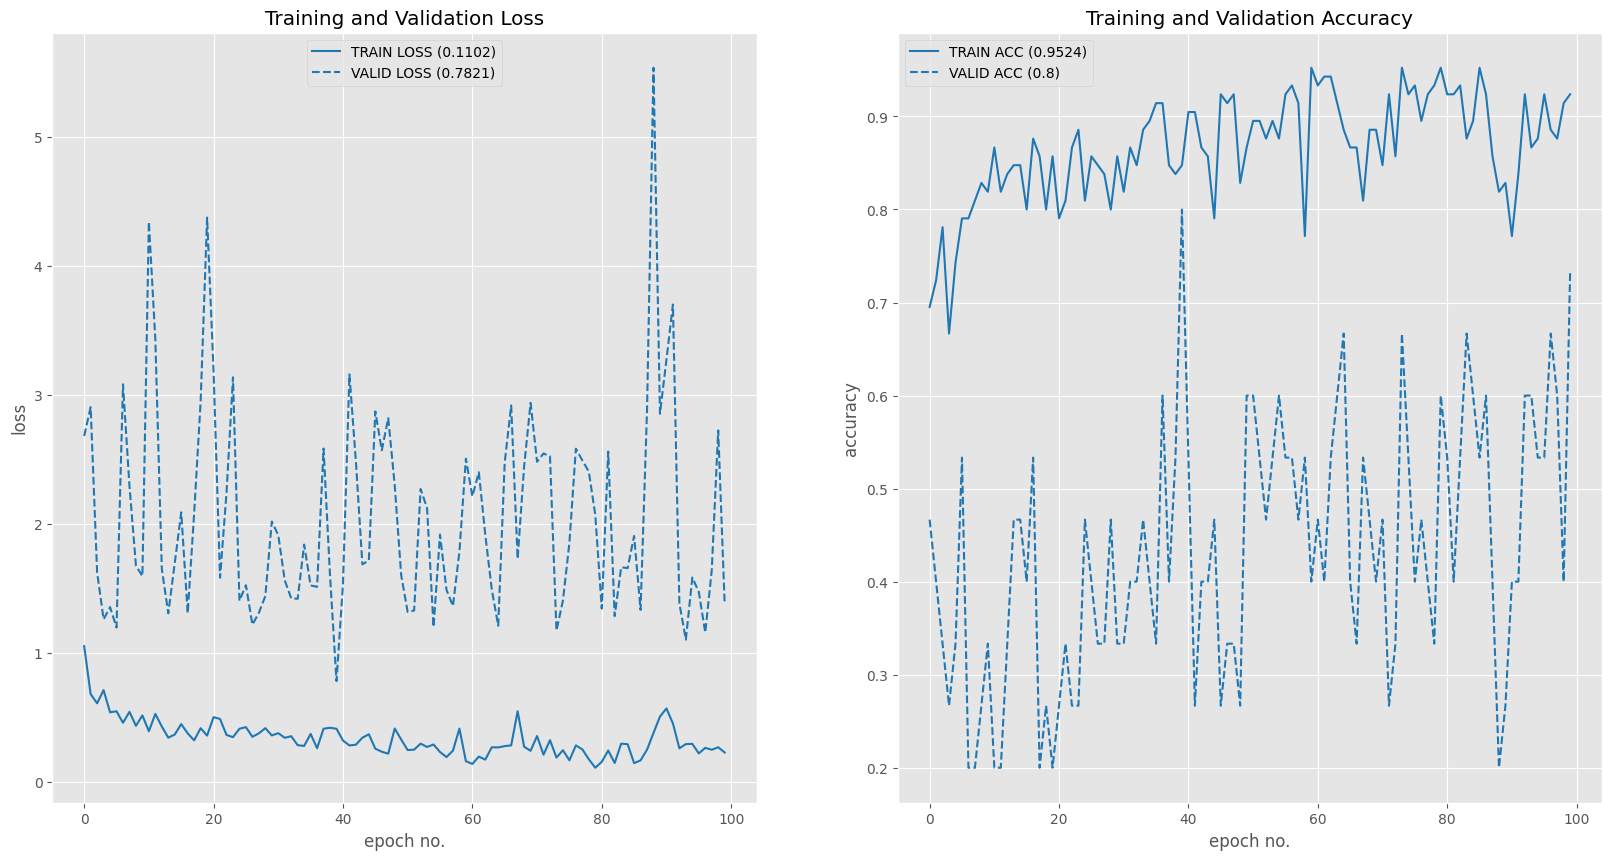

Training Accuracy: 92.38%
Validation Accuracy: 73.33%


In [57]:
plot_loss_accuracy(
    train_loss=[train_loss],
    val_loss=[val_loss],
    train_acc=[train_acc],
    val_acc=[val_acc],
    colors=["blue"],
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
)

def print_model_accuracy(train_acc, val_acc):
    """
    Print the training and validation accuracy of the model.
    
    Args:
        train_acc (list): List of training accuracy values
        val_acc (list): List of validation accuracy values
    """
    # Get the final accuracy values (last element in the lists)
    final_train_acc = train_acc[-1]
    final_val_acc = val_acc[-1]
    
    print(f"Training Accuracy: {final_train_acc:.2%}")
    print(f"Validation Accuracy: {final_val_acc:.2%}")
    
    # Print performance comparison
    if final_val_acc > final_train_acc:
        print("Note: Validation accuracy is higher than training accuracy")
    elif final_train_acc - final_val_acc > 0.05:
        print("Warning: Model might be overfitting (training accuracy significantly higher)")


print_model_accuracy(train_acc, val_acc)

# <font style="color:blue">Step 5. Sample Prediction</font><a name="step5"></a>

Show some sample predictions.

## <font style="color:blue">5.1. Make Predictions</font>

In [58]:
def prediction(model, device, batch_input):
    data = batch_input.to(device)

    with torch.no_grad():
        output = model(data)

    # Score to probability using softmax.
    prob = F.softmax(output, dim=1)

    # Get the max probability.
    pred_prob = prob.data.max(dim=1)[0]

    # Get the index of the max probability.
    pred_index = prob.data.max(dim=1)[1]

    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

## <font style="color:blue">5.2. Get Predictions on a Batch</font>

In [59]:
def get_sample_prediction(model, data_root, img_size, mean, std):
    batch_size = 15

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2

    # It is important to do model.eval() before prediction.
    model.eval()

    # Send model to cpu/cuda according to your system configuration.
    model.to(device)

    # Transformed data
    valid_dataset_trans = datasets.ImageFolder(root=data_root, transform=image_common_transforms(img_size, mean, std))

    # Original image dataset
    valid_dataset = datasets.ImageFolder(root=data_root, transform=image_preprocess_transforms(img_size))

    data_len = valid_dataset.__len__()

    interval = int(data_len / batch_size)

    imgs = []
    inputs = []
    targets = []
    for i in range(batch_size):
        index = i * interval
        trans_input, target = valid_dataset_trans.__getitem__(index)
        img, _ = valid_dataset.__getitem__(index)

        imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)

    inputs = torch.stack(inputs)

    cls, prob = prediction(model, device, batch_input=inputs)

    plt.style.use("default")
    plt.rcParams["figure.figsize"] = (15, 9)
    fig = plt.figure()

    for i, target in enumerate(targets):
        plt.subplot(3, 5, i + 1)
        img = transforms.functional.to_pil_image(imgs[i])
        plt.imshow(img)
        plt.gca().set_title(f"P:{valid_dataset.classes[cls[i]]}({prob[i]:.2}), T:{valid_dataset.classes[targets[i]]}")
    plt.show()

    return

## <font style="color:blue">5.3. Load Model and Run Inference</font>

Next, we will reload the best saved model and use the `get_sample_prediction` function to make some sample predictions. This step is instrumental in visually assessing the performance of our model on the validation dataset, providing a quick and practical insight into how well our model generalizes to new, unseen data.


<ipython-input-39-4bb1e7806922>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


mean: tensor([0.4573, 0.4348, 0.3884]), std: tensor([0.2686, 0.2601, 0.2600])


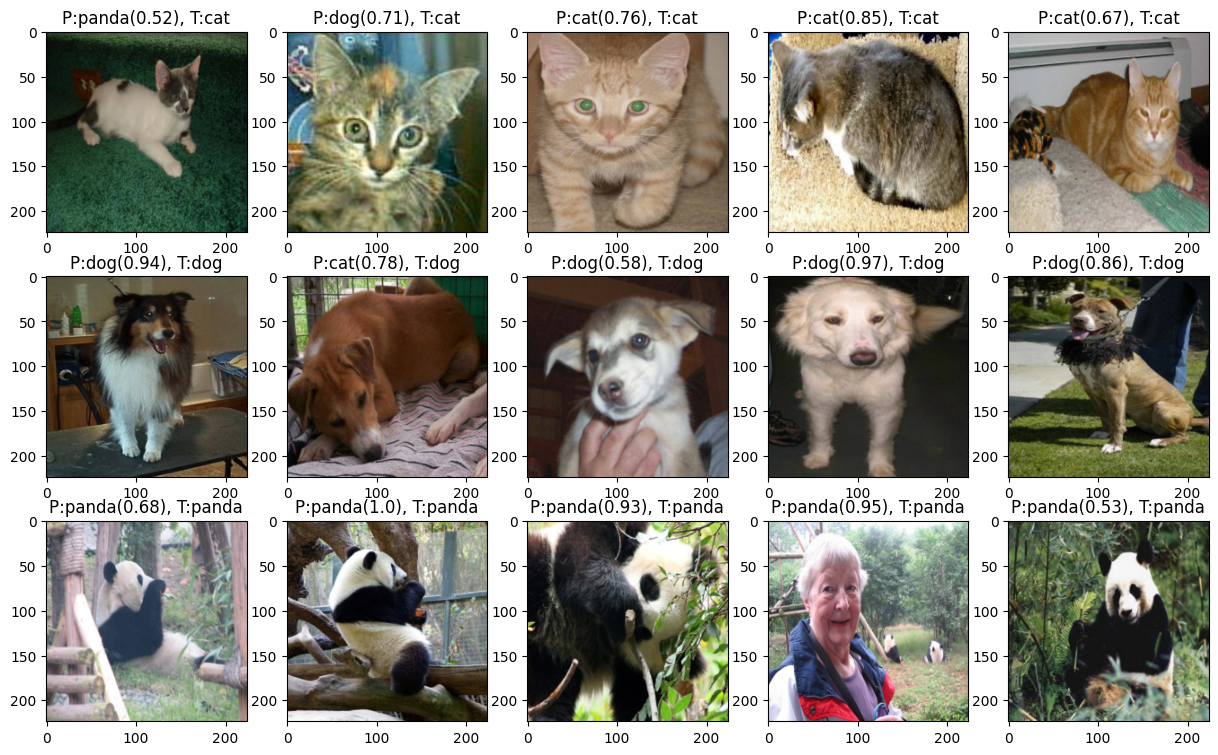

In [60]:
trained_model = MyModel()
trained_model = load_model(
    trained_model, 
    model_dir=training_config.checkpoint_dir, 
    model_file_name=training_config.save_model_name
)

train_data_path = os.path.join(training_config.data_root, "Train")
valid_data_path = os.path.join(training_config.data_root, "Valid")

mean, std = get_mean_std(train_data_path, img_size=training_config.img_size)

get_sample_prediction(trained_model, valid_data_path, img_size=training_config.img_size, mean=mean, std=std)

# <font style="color:red">Step 6. Display Confusion Matrix [5 Points]</font>

Display the confusion matrix (Refer to the earlier lectures on Performance Metrics for this).


This is what the output should look like:

<img src='https://www.dropbox.com/scl/fi/pgl21i5viwohke8hr4jm9/c3_w5_sample_confusion_matrix.jpg?rlkey=4c1vvwajedudrn5f99lwdpbi6&dl=1' width=600>



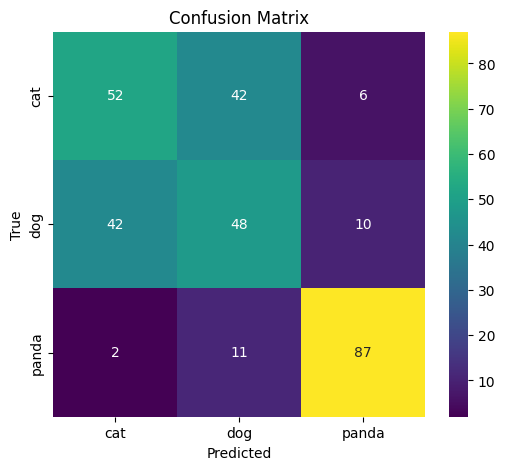

In [61]:
# YOUR CODE HERE
import seaborn as sns
from torchmetrics.classification import MulticlassConfusionMatrix


def compute_confusion_matrix(model, data_root, img_size, mean, std, num_classes=3):
   
    class_labels = ["cat", "dog", "panda"]  # Explicit class labels

    # Select device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Set model to evaluation mode
    model.eval()
    model.to(device)

    # Load dataset with transformations
    valid_dataset_trans = datasets.ImageFolder(root=data_root, transform=image_common_transforms(img_size, mean, std))
    valid_dataset = datasets.ImageFolder(root=data_root, transform=image_preprocess_transforms(img_size))

    # Get sample indices for visualization
    data_len = len(valid_dataset)
   

    imgs, inputs, targets = [], [], []
    for i in range(data_len):
        index = i 
        trans_input, target = valid_dataset_trans[index]
        img, _ = valid_dataset[index]

        imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)

    # Convert inputs to tensor batch
    inputs = torch.stack(inputs).to(device)

    # Get predictions from the model
    cls, prob = prediction(model, device, batch_input=inputs)  # Model inference

    # Compute confusion matrix
    cm = MulticlassConfusionMatrix(num_classes=num_classes)
    conf_matrix = cm(torch.tensor(cls), torch.tensor(targets))

    # Plot confusion matrix with proper colorbar handling
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(conf_matrix.numpy(), annot=True, fmt="d", cmap="viridis",
                     xticklabels=class_labels, yticklabels=class_labels, cbar=True)

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    return

compute_confusion_matrix(trained_model, valid_data_path, img_size=training_config.img_size, mean=mean, std=std)

# <font style="color:red">Step 7. Generate Submission File [10 Points]</font>


**TASK**

1. Generate predictions on the test set.
2. Create a submission `.csv` file.
3. Upload the `.csv` file on Kaggle.


**REFERENCE**
1. **`test.csv`** -  This CSV file contains image IDs for the test set. Read this CSV file to generate predictions for each test image.

2. **`sample_submission.csv`** - Refer to this file to understand the structure of the csv file to be submitted. The sample_submission file is only to be used as reference. <br>
It contains columns:
    1. **`ID`**: same as the test.csv file
    2. **`CLASS`**: which contains random predictions




**<font style="color:red">Use the same column names that are given in the`sample_submission.csv` file.</font>**


In [62]:
import pandas as pd
from torchvision.datasets import DatasetFolder
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# Load the test CSV
test_df = pd.read_csv("/kaggle/input/opencv-pytorch-project-1-classification/test.csv")

# Get the image IDs
image_ids = test_df["ID"]
print(len(image_ids))
print(image_ids)

# Select device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define dataset class for loading test images
class CustomTestDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]  # File name
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, img_name

# Image transformations for model input
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust based on model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_csv="/kaggle/input/opencv-pytorch-project-1-classification/test.csv"
test_img_dir="/kaggle/input/opencv-pytorch-project-1-classification/dataset/Test"

# Load test dataset
test_dataset = CustomTestDataset(csv_file=test_csv, img_dir=test_img_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define class labels
class_labels = ["cat", "dog", "panda"]

# Store results
results = []


# Loop through test images
for images, img_paths in test_loader:
  preds, probs = prediction(model, device, images)  # Use prediction function
   
    # Collect results
  for img_path, pred in zip(img_paths, preds):
    filename = os.path.basename(img_path)  # Extract filename
    predicted_class = class_labels[pred]
    results.append([filename, predicted_class])


# Convert to DataFrame
results_df = pd.DataFrame(results, columns=['ID', 'Class'])

# Save to CSV
results_df.to_csv("submission.csv", index=False)
print("finished submission.csv saved")




600
0      110300.jpg
1      125600.jpg
2      150300.jpg
3      155300.jpg
4      117000.jpg
          ...    
595    107400.jpg
596    135300.jpg
597    122100.jpg
598    114700.jpg
599    155000.jpg
Name: ID, Length: 600, dtype: object
finished submission.csv saved


## <font style="color:red">Step 8. Kaggle Submission Score [40 Points]</font>

**For full points, you need to achieve atleast `85%` accuracy on the Public Test leaderboard. If accuracy is less than `80%`, you gain no points for this section.**


**Submit `submission.csv` (prediction for images in `test.csv`), in the `Submit Predictions` tab in Kaggle, in order to get evaluated for this section.**

**Please share your profile link, user id and score achieved.**

```
URL:
Profile Name:
Points Scored:
```

**Upon completing the project, <font style="color:red">upload the notebook to the lab for grading and feedback.</font>**

**<font style="color:red">Please do not make your notebooks public or publish them on the competition page. You only need to submit your notebook to the lab. This is to make sure that students don't copy each other.</font>**